{'infer_column_types': 'False', 'activity': 'download'}
{'infer_column_types': 'False', 'activity': 'download', 'activityApp': 'FileDataset'}
[Info] read from /var/folders/m1/v2p5dlc135x8ctp72qfss6200000gn/T/tmpe5t5l3bo/https%3A/%2Fazureopendatastorage.azurefd.net/nyctlc/green/puYear=2016/puMonth=1/part-00119-tid-4753095944193949832-fee7e113-666d-4114-9fcb-bcd3046479f3-2689-1.c000.snappy.parquet
[Info] read from /var/folders/m1/v2p5dlc135x8ctp72qfss6200000gn/T/tmpe5t5l3bo/https%3A/%2Fazureopendatastorage.azurefd.net/nyctlc/green/puYear=2016/puMonth=2/part-00060-tid-4753095944193949832-fee7e113-666d-4114-9fcb-bcd3046479f3-2630-2.c000.snappy.parquet
[Info] read from /var/folders/m1/v2p5dlc135x8ctp72qfss6200000gn/T/tmpe5t5l3bo/https%3A/%2Fazureopendatastorage.azurefd.net/nyctlc/green/puYear=2016/puMonth=3/part-00196-tid-4753095944193949832-fee7e113-666d-4114-9fcb-bcd3046479f3-2766-1.c000.snappy.parquet
Index(['vendorID', 'lpepPickupDatetime', 'lpepDropoffDatetime',
       'passengerCount'

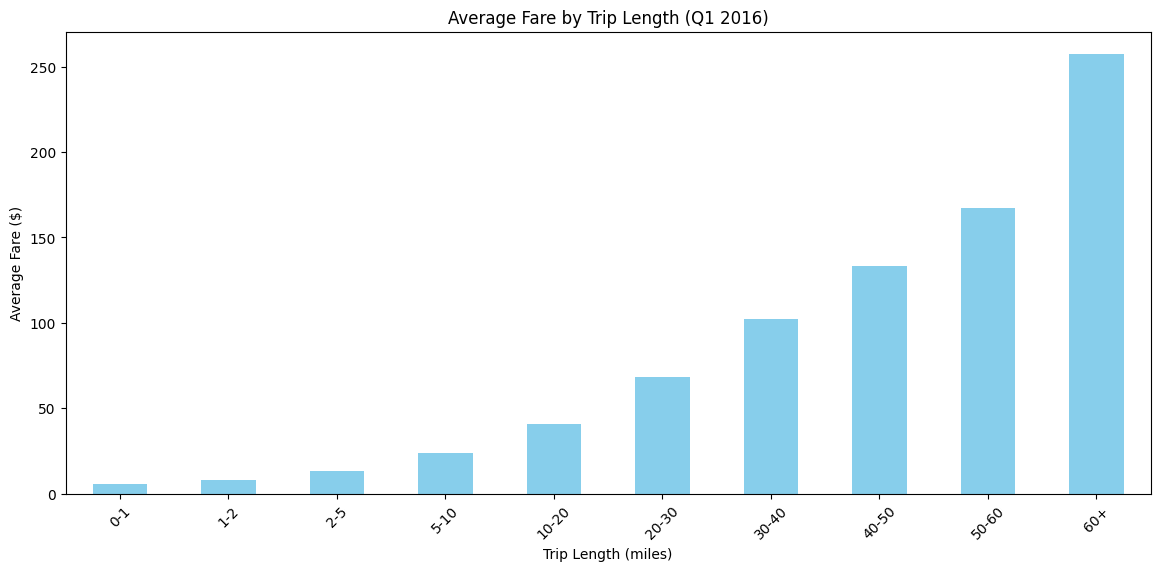

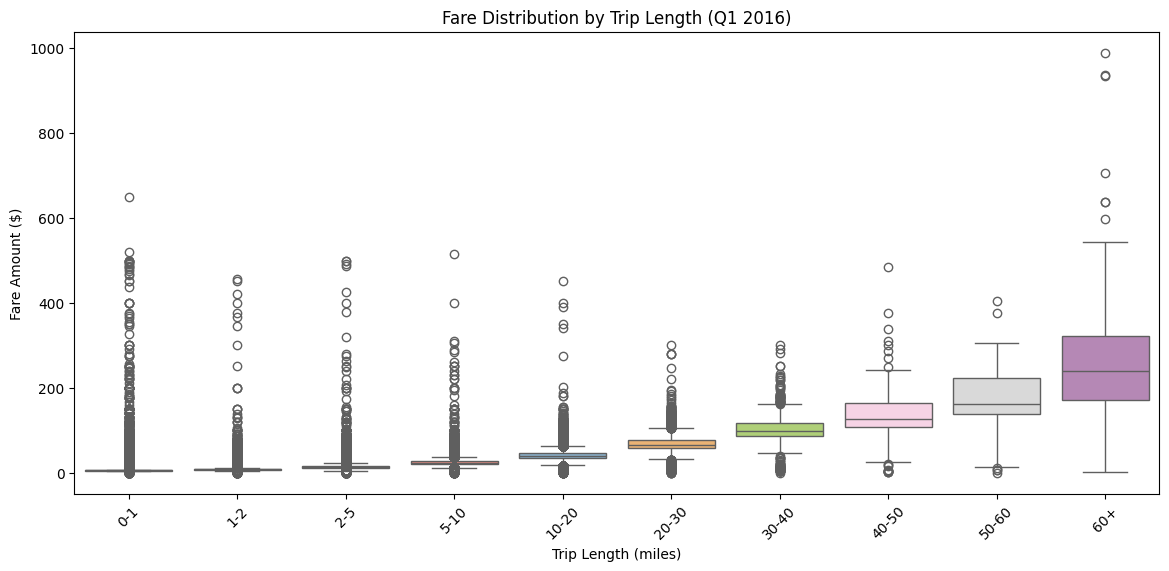

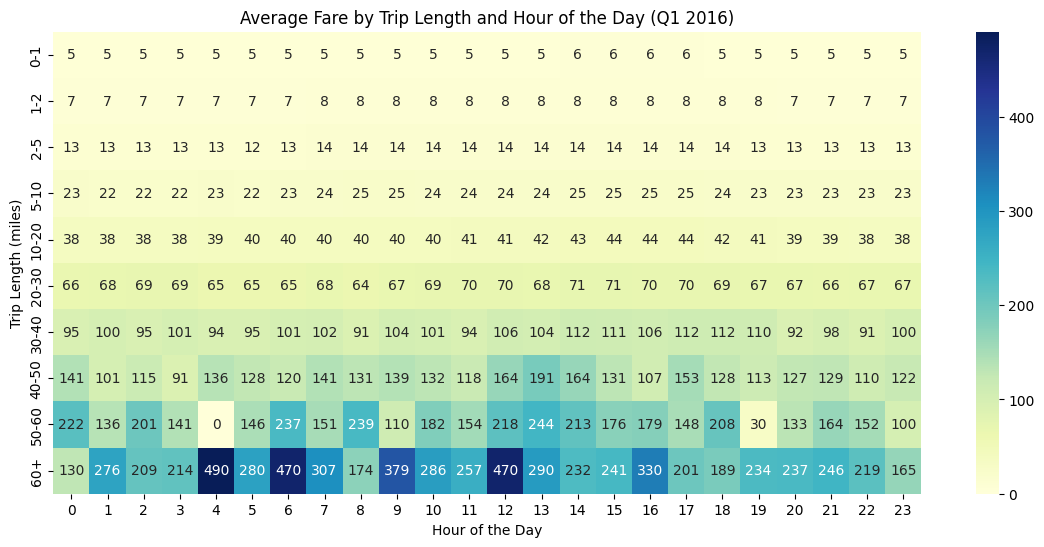

In [13]:
# Import necessary libraries
from azureml.opendatasets import NycTlcGreen
from datetime import datetime
from dateutil import parser
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import logging

# Set the logging level to ERROR to suppress verbose logging
logging.getLogger('azureml.opendatasets').setLevel(logging.ERROR)

# Set the date range for Q1 2016
start_date = parser.parse('2016-01-01')
end_date = parser.parse('2016-03-31')

# Fetch the dataset
nyc_tlc = NycTlcGreen(start_date=start_date, end_date=end_date)
nyc_tlc_df = nyc_tlc.to_pandas_dataframe()

# Display the columns to verify the names
print(nyc_tlc_df.columns)

# Ensure necessary columns are present
if 'tripDistance' not in nyc_tlc_df.columns or 'fareAmount' not in nyc_tlc_df.columns:
    print("Columns 'tripDistance' or 'fareAmount' not found. Available columns are:")
    print(nyc_tlc_df.columns)
else:
    # Remove rows with zero or negative trip distances and fares for analysis
    nyc_tlc_df = nyc_tlc_df[(nyc_tlc_df['tripDistance'] > 0) & (nyc_tlc_df['fareAmount'] > 0)].copy()

    # Define trip length categories
    bins = [0, 1, 2, 5, 10, 20, 30, 40, 50, 60, float('inf')]
    labels = ['0-1', '1-2', '2-5', '5-10', '10-20', '20-30', '30-40', '40-50', '50-60', '60+']
    nyc_tlc_df.loc[:, 'trip_length_category'] = pd.cut(nyc_tlc_df['tripDistance'], bins=bins, labels=labels, right=False)

    # Compute average fares for each trip length category
    average_fares = nyc_tlc_df.groupby('trip_length_category')['fareAmount'].mean()

    # Plot average fares by trip length category
    plt.figure(figsize=(14, 6))
    average_fares.plot(kind='bar', color='skyblue')
    plt.title('Average Fare by Trip Length (Q1 2016)')
    plt.xlabel('Trip Length (miles)')
    plt.ylabel('Average Fare ($)')
    plt.xticks(rotation=45)
    plt.show()

    # Plot fare distribution for various trip lengths
    plt.figure(figsize=(14, 6))
    sns.boxplot(x='trip_length_category', y='fareAmount', hue='trip_length_category', data=nyc_tlc_df, palette='Set3', dodge=False)
    plt.legend([], [], frameon=False)  # Hide the legend
    plt.title('Fare Distribution by Trip Length (Q1 2016)')
    plt.xlabel('Trip Length (miles)')
    plt.ylabel('Fare Amount ($)')
    plt.xticks(rotation=45)
    plt.show()

    # Create a pivot table for the heatmap
    heatmap_data = nyc_tlc_df.pivot_table(values='fareAmount', index='trip_length_category', columns=nyc_tlc_df['lpepPickupDatetime'].dt.hour, aggfunc='mean')
    heatmap_data = heatmap_data.round(0).astype(int)  # Round and convert to integers

    # Plot heatmap of fare distribution by trip length and hour of the day
    plt.figure(figsize=(14, 6))
    sns.heatmap(heatmap_data, cmap='YlGnBu', annot=True, fmt=".0f")
    plt.title('Average Fare by Trip Length and Hour of the Day (Q1 2016)')
    plt.xlabel('Hour of the Day')
    plt.ylabel('Trip Length (miles)')
    plt.show()
    
